<b>Coding to Julia 1.0.5</b>

微粒子Brown運動の系を考える.

In [1]:
using Distributions


#conditions
m = 1.0 #mass
γ = 1.0 #resistance coefficient

x₀ = 0.0 #initial position
v₀ = 0.0 #initial velocity

N = 500 #time step
M = 10000 #number of samples
tₘᵢₙ = 0.0
tₘₐₓ = 30.0
Δt = (tₘₐₓ - tₘᵢₙ)/N #time step width

kT = 1.0 #k:Boltzmann constant, T:temperature
σ = sqrt(2*γ*kT/Δt) #σ:fluctuation


function Random()
    η = rand(Normal(0, σ), 1)[end] #random force
    return η
end 
η = Random()

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1192


4.9638149477571085

Brownian motionを記述する運動方程式としては, Langevin方程式がある．

いま,一次元で粒子の運動を考え,時刻 $t$ における粒子の位置を $x(t)$ とすると,一次元Langevin方程式は

$$ m\frac{d^2x}{dt^2}(t) = -\gamma\frac{dx}{dt}(t) + \eta(t) $$

のような形で与えられる．

In [2]:
#Langevin equation discretization
function Langevin(xᵢ,vᵢ,η)
    vᵢ₊₁ = vᵢ - ((γ*vᵢ - η)/m) * Δt
    xᵢ₊₁ = xᵢ + vᵢ*Δt
    vᵢ = vᵢ₊₁
    xᵢ = xᵢ₊₁
    return xᵢ, vᵢ
end

Langevin(x₀,v₀,η)

(0.0, 0.2978288968654265)

ここで,時刻 $t = t_0$ のときの位置を $x_0$ , 時刻 $t = t_i$ のときの位置を $x_i$ とすると,Brown運動の抽出サンプル数 $N$ に対する二乗平均ゆらぎ $<R^2>$ は次式で与えられる.

$$ <R^2> = \frac{1}{N}\sum^N_{i=1}(x_i-x_0)^2 $$


In [3]:
ΣR²_list = zeros(N+1) #sum of squared of R
R²ₐᵥₑ_list = [] # list of mean-square value <R²>
xᵢ⁽ʲ⁾_list = [] # list of displacement x (xᵢ⁽ʲ⁾ is i-by-j matrix)
xᵢ⁽ʲ⁾²_list = []

for j in 1:M  # j is iteration of samples
    #variable initialization
    R²_list = zeros()
    x_list = [x₀]
    x²_list = [x₀^2]
    x,v = x₀, v₀
    for i in 1:N  # i is time step of samples
        η = Random() #random force
        x,v = Langevin(x,v,η)
        x_list = hcat(x_list,[x]) # hcat is that function Adding elements
        x²_list = hcat(x²_list,[x^2])
        R²_list = hcat(R²_list, [(x-x₀)^2]) # end-to-end distance R = x - x₀
    end
    xᵢ⁽ʲ⁾_list = vcat(xᵢ⁽ʲ⁾_list,[x_list'])
    xᵢ⁽ʲ⁾²_list = vcat(xᵢ⁽ʲ⁾²_list,[x²_list'])
    ΣR²_list += vec(R²_list)
end

R²ₐᵥₑ_list = ΣR²_list/M

501-element Array{Float64,1}:
  0.0                   
  0.0                   
  0.00044022724516532057
  0.002067930375203468  
  0.005465593279513451  
  0.011180340936227662  
  0.01953874172743247   
  0.03093679062824094   
  0.04557089893438224   
  0.06377970939673269   
  0.08554514551775715   
  0.1110068457183231    
  0.1399907366064901    
  ⋮                     
 56.936064587437265     
 57.04979477895848      
 57.16494720894389      
 57.27584478472591      
 57.379153350830535     
 57.48455843892334      
 57.59547393562571      
 57.704326893576045     
 57.81370697921788      
 57.922771714808114     
 58.03997523653851      
 58.16173962686593      

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192


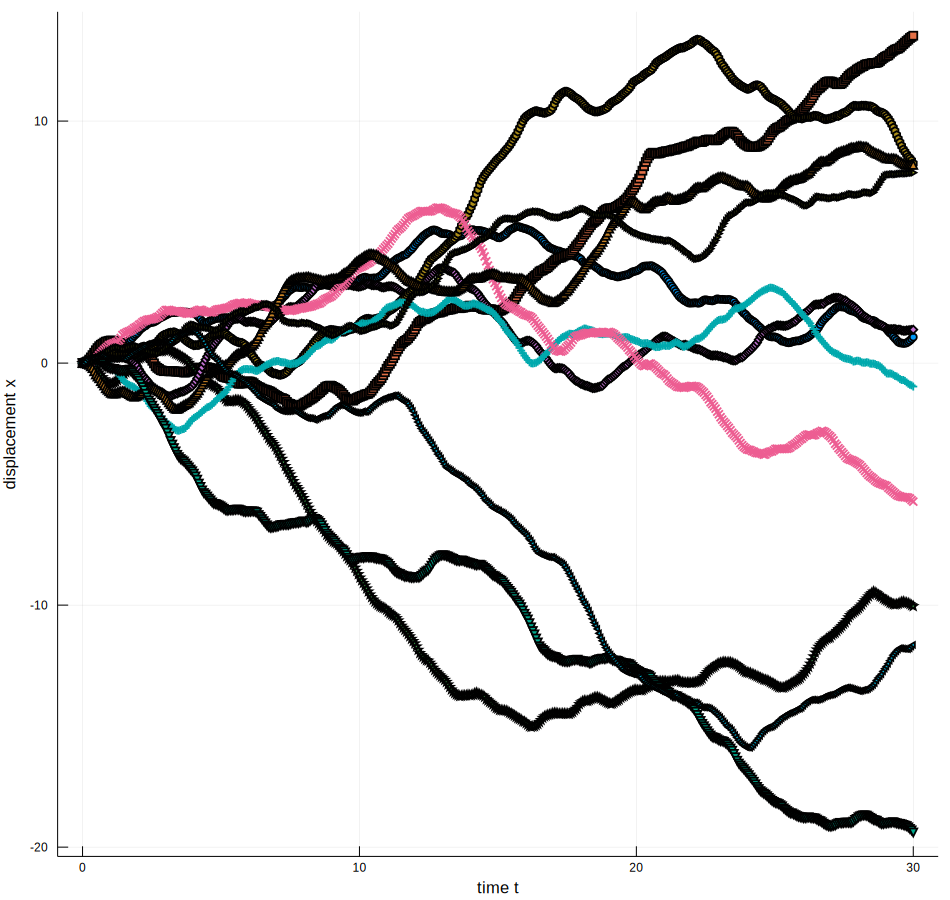

In [4]:
using Plots
gr()
plot(
    plot([tₘᵢₙ:Δt:tₘₐₓ], xᵢ⁽ʲ⁾_list[20:30], marker = :auto, legend = :none, xlabel="time t", ylabel="displacement x"),
    size = (950,900)
    )

grad(<R²>) = 2.025244681193105

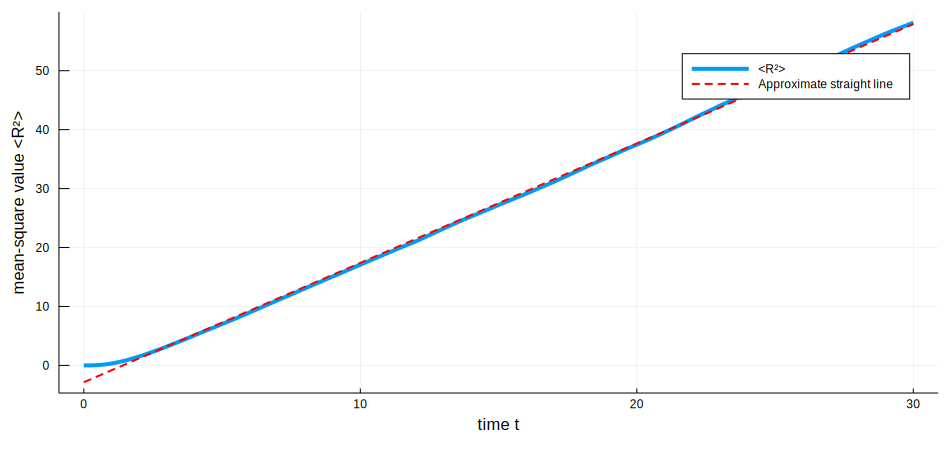

In [5]:
using Plots
gr()

t_list = [tₘᵢₙ]
for i in 1:N  # i is time step of samples
    t_list = hcat(t_list, [i*Δt]) 
end

vec(t_list)
a = cov(t_list',R²ₐᵥₑ_list)[end] / std(t_list')^2
b = mean(R²ₐᵥₑ_list)-a*mean(t_list)
b_list = [b]

for i in 1:N  # i is time step of samples
    b_list = hcat(b_list, [b]) 
end
y = vec(a*t_list+b_list)

print("grad(<R²>) = ",a[end])

plot(t_list', R²ₐᵥₑ_list, linewidth=4, label="<R²>", xlabel="time t", ylabel="mean-square value <R²>",size=(950,450))
plot!(t_list', y, color=:red, linewidth=2, linestyle=:dash, label="Approximate straight line", xlabel="time t", ylabel="mean-square value <R²>",size=(950,450))